In [93]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [128]:
# input files:

# scan_name = 'FeBpy_fluence_scan_7123eV_5ps_001'
# f         = "FeBpy_fluence_scan_7123eV_5ps_001_step0000.BSREAD.h5"

scan_name = 'wph_scan_007'
f         = 'wph_scan_007_step0001.BSREAD.h5'

DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

In [129]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 38G
drwxrwsr-x. 164 17983 p17983  32K Jul 28 12:00 ..
-rw-r--r--.   1 17983 p17983  12G Jul 28 12:00 wph_scan_007_step0000.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983  16G Jul 28 12:00 wph_scan_007_step0000.JF06T32V01.h5
drwxr-sr-x.   2 17983 p17983 4.0K Jul 28 12:01 .
-rw-r--r--.   1 17983 p17983 4.2G Jul 28 12:01 wph_scan_007_step0001.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983 6.0G Jul 28 12:01 wph_scan_007_step0001.JF06T32V01.h5
ra-c-003.psi.ch
There are 4 files in the folder /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/


# Load one step and filter some data from I0

In [130]:
fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Waveplate_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(fn, channel_waveplate)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()
print (np.median(IzeroFEL_pump_shot) - 1.2*(np.std(IzeroFEL_pump_shot)))

conditionPumpMax = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+4*(np.std(IzeroFEL_pump_shot))
conditionPumpMin = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-4*(np.std(IzeroFEL_pump_shot))

conditionUnPumpMax = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+4*(np.std(IzeroFEL_unpump_shot))
conditionUnPumpMin = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-4*(np.std(IzeroFEL_unpump_shot))

conditionGeneral = IzeroFEL_pump_shot > 0.005
conditionGeneral2 = IzeroFEL_unpump_shot > 0.005

IzeroFEL_pump_shot = IzeroFEL_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)

#######

#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_pump_original, bins =np.arange(0,0.2,0.005), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.2,0.005), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)


plt.title(DIR)
plt.show()
print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

w_value=np.mean(Waveplate_shot)
pump = np.mean(DataFluo_pump_shot/IzeroFEL_pump_shot)
unpump = np.mean(DataFluo_unpump_shot/IzeroFEL_unpump_shot)
value=pump-unpump
print(w_value)
print(value)


OSError: Unable to open file (unable to open file: name = '/sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0001.BSREAD.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Load time scan

In [160]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Waveplate_deg = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: # and i!=10:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Waveplate_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(filename, channel_waveplate)
        
        
        #load_XAS(filename, channel_waveplate)
        
        threshold_pump = IzeroFEL_pump_shot > 0.005
        threshold_unpump = IzeroFEL_unpump_shot > 0.005
        condition_pump = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-2*(np.std(IzeroFEL_pump_shot))
        condition_unpump = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-2*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
              
        DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
    
              
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        DataTrans_pump_shot_norm = DataTrans_pump_shot / IzeroFEL_pump_shot
        DataTrans_unpump_shot_norm = DataTrans_unpump_shot / IzeroFEL_unpump_shot
              
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        DataFluo_pump.append(DataFluo_pump_shot_norm.mean())
        DataFluo_unpump.append(DataFluo_unpump_shot_norm.mean())
        DataTrans_pump.append(DataTrans_pump_shot_norm.mean())
        DataTrans_unpump.append(DataTrans_unpump_shot_norm.mean())
        
        Pump_probe.append(Pump_probe_shot.mean())
        
        err_DataFluo_pump.append(DataFluo_pump_shot_norm.std()/np.sqrt(DataFluo_pump_shot_norm.size))
        err_DataFluo_unpump.append(DataFluo_unpump_shot_norm.std()/np.sqrt(DataFluo_unpump_shot_norm.size))
        err_DataTrans_pump.append(DataTrans_pump_shot_norm.std()/np.sqrt(DataTrans_pump_shot_norm.size))
        err_DataTrans_unpump.append(DataTrans_unpump_shot_norm.std()/np.sqrt(DataTrans_unpump_shot_norm.size))
              
        err_Pump_probe.append(Pump_probe_shot.std()/np.sqrt(Pump_probe_shot.size))
               
        Waveplate_shot = [x for x in Waveplate_shot if (np.abs(x) > 0)]
        Waveplate_deg.append(np.mean(Waveplate_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)


DataTrans_pump = np.asarray(DataTrans_pump)
DataTrans_unpump = np.asarray(DataTrans_unpump)
              
Pump_probe = np.asarray(Pump_probe)
err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
err_DataTrans_pump = np.asarray(err_DataTrans_pump)
err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Waveplate_deg = np.asarray(Waveplate_deg)

print ("Job done!")


/sf/alvra/data/p17983/res/scan_info/wph_scan_007_scan_info.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0000.BSREAD.h5
step 2 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0001.BSREAD.h5
step 3 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0002.BSREAD.h5
step 4 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0003.BSREAD.h5
step 5 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0004.BSREAD.h5
step 6 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0005.BSREAD.h5
step 7 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0006.BSREAD.h5
step 8 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/wph_scan_007/wph_scan_007_step0007.BSREAD.h5
step 9 of 21 : Processing /sf/alvra/data/p17983/raw/scan_dat

In [25]:
# #correlation
# plt.figure()
# plt.plot(DataFluo_pump_shot,IzeroFEL_pump_shot,'.')
# #plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

# plt.title(DIR)
# plt.show()
# print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

[-41.9375 -41.4875 -40.925  -40.475  -39.9125 -39.4625 -38.9    -38.45
 -38.     -37.4375 -36.9875 -36.425  -35.975  -35.4125 -34.9625 -34.4
 -33.95   -33.5    -32.9375 -32.4875]
[0.23128472 0.20537834 0.23315635 0.30350086 0.45155567 0.61806322
 0.8862099  1.14867253 1.45368374 1.89466606 2.29512047 2.85511207
 3.35050951 4.02881098 4.6185327  5.41429683 6.09760628 6.82224324
 7.78588291]


<IPython.core.display.Javascript object>


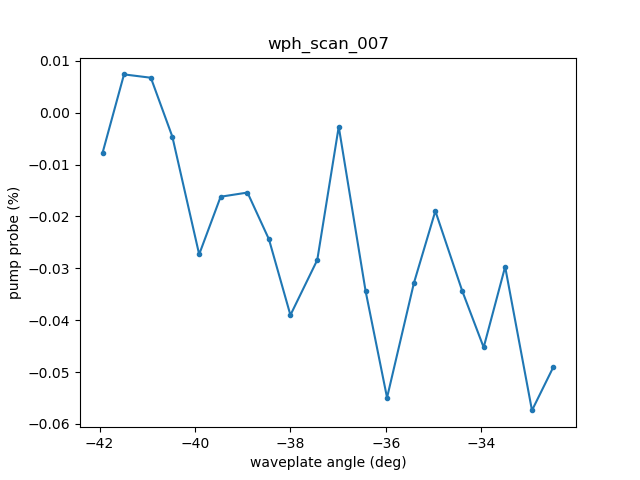

Text(0.5, 0, 'waveplate angle (deg)')

In [161]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(scan_name)
plt.plot(Waveplate_deg, Pump_probe/DataFluo_unpump, marker = '.')
plt.ylabel('pump probe (%)')
plt.xlabel('waveplate angle (deg)')

In [162]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

In [95]:
print (0.20514 +346.78 * (np.cos(np.pi/180*(-34-768.56)))**2)

6.019638974238845


# Plot fluence scans

[-41.9375 -41.4875 -40.925  -40.475  -39.9125 -39.4625 -38.9    -38.45
 -38.     -37.4375 -36.9875 -36.425  -35.975  -35.4125 -34.9625 -34.4
 -33.95   -33.5    -32.9375 -32.4875]
[0.23128472 0.20537834 0.23315635 0.30350086 0.45155567 0.61806322
 0.8862099  1.14867253 1.45368374 1.89466606 2.29512047 2.85511207
 3.35050951 4.02881098 4.6185327  5.41429683 6.09760628 6.82224324
 7.78588291 8.60283759]


<IPython.core.display.Javascript object>


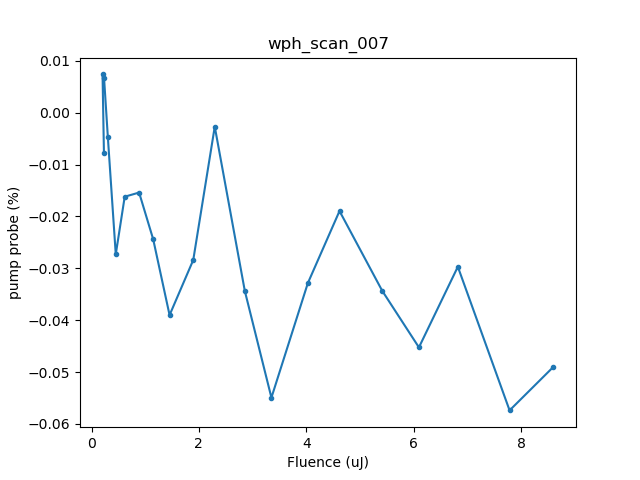

Text(0, 0.5, 'pump probe (%)')

In [163]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(scan_name)
plt.plot(fluences, Pump_probe/DataFluo_unpump, marker = '.')
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')

[-41.9375 -41.4875 -40.925  -40.475  -39.9125]
[0.23128472 0.20537834 0.23315635 0.30350086 0.45155567 0.61806322
 0.8862099  1.14867253 1.45368374 1.89466606 2.29512047 2.85511207
 3.35050951 4.02881098 4.6185327  5.41429683 6.09760628 6.82224324
 7.78588291 8.60283759 9.68125394]


<IPython.core.display.Javascript object>


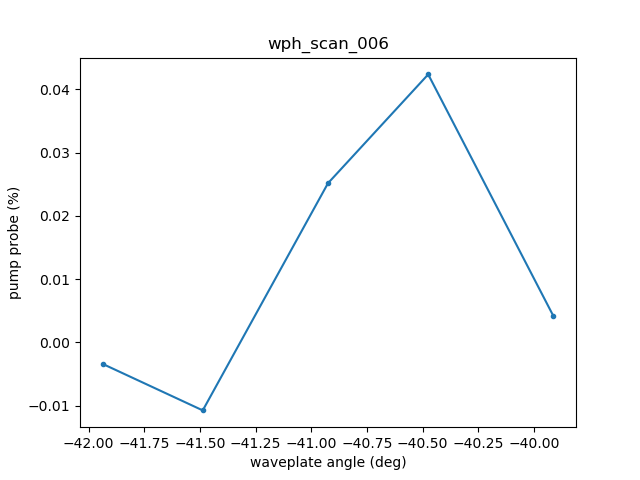

Text(0.5, 0, 'waveplate angle (deg)')

In [106]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(scan_name)
plt.plot(Waveplate_deg, Pump_probe/DataFluo_unpump, marker = '.')
plt.ylabel('pump probe (%)')
plt.xlabel('waveplate angle (deg)')

<IPython.core.display.Javascript object>


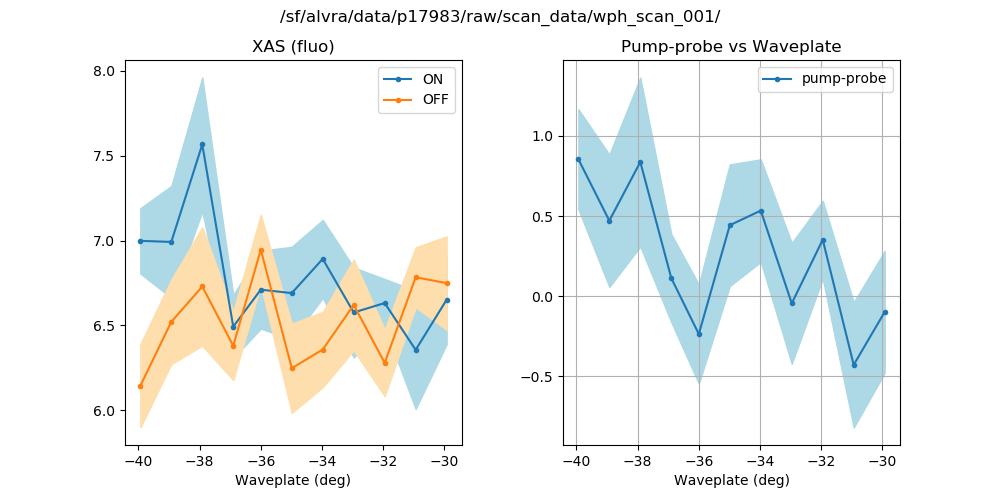

In [82]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Waveplate_deg, scale*DataFluo_pump, label="ON",marker='.')
plt.plot(Waveplate_deg, scale*DataFluo_unpump, label="OFF",marker='.')
plt.fill_between(Waveplate_deg, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Waveplate_deg, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Waveplate (deg)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")


# To plot pp vs waveplate - WARNING: the waveplate-to-fluence relationship ISN'T linear!
plt.subplot(1,2,2)
plt.plot(Waveplate_deg, scale*(Pump_probe), label="pump-probe",marker='.')
plt.fill_between(Waveplate_deg, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("Waveplate (deg)")
# plt.xlabel("Fluence (mJ/cm^2)")
plt.gca().set_title('Pump-probe vs Waveplate')
plt.legend(loc="best")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

# # To plot pp vs fluence:
# plt.subplot(1,2,2)
# plt.plot(fluences, scale*(Pump_probe), label="pump-probe",marker='.')
# plt.fill_between(fluences, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
# plt.grid()
# plt.xlabel("Fluence (mJ/cm^2)")
# plt.gca().set_title('Pump-probe vs Fluence')
# plt.legend(loc="best")
# plt.legend(loc="best")
# plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

## Sum WP Scans

In [99]:
# Waveplate_deg_10p=Waveplate_deg.copy()
# Pump_probe_01=Pump_probe.copy()
# err_Pump_probe_01=err_Pump_probe.copy()
# # scan2 is broken
# Pump_probe_03=Pump_probe.copy()
# err_Pump_probe_03=err_Pump_probe.copy()
# Pump_probe_04=Pump_probe.copy()
# err_Pump_probe_04=err_Pump_probe.copy()

In [107]:
# Pump_probe_sum_10points = Pump_probe_01 + Pump_probe_03 + Pump_probe_04
# err_Pump_probe_sum_10points=np.sqrt((err_Pump_probe_01)**2 + (err_Pump_probe_03)**2 + (err_Pump_probe_04)**2 )

# # save the output into a separate file:
# Waveplate_deg_10p = np.array([71.4375, 70.0875, 68.625 , 67.275 , 65.8125, 64.4625, 63.    ,     61.65  , 60.3   , 58.8375])
# Fluences_10p = [20,29,48,66,90,120,150,180,230,260]
# Pump_probe_sum_10points = np.array([-0.77826836,  0.80302329,  1.91875015,  2.82471344,  4.40338911,         3.75789497,  5.10986286,  5.84922088,  7.06680331,  6.23510603])
# err_Pump_probe_sum_10points = np.array([0.93184996, 0.83489726, 0.80869364, 0.97283342, 0.87707019,        0.82734931, 0.9564096 , 0.99325213, 0.91433509, 0.94807469])

<IPython.core.display.Javascript object>


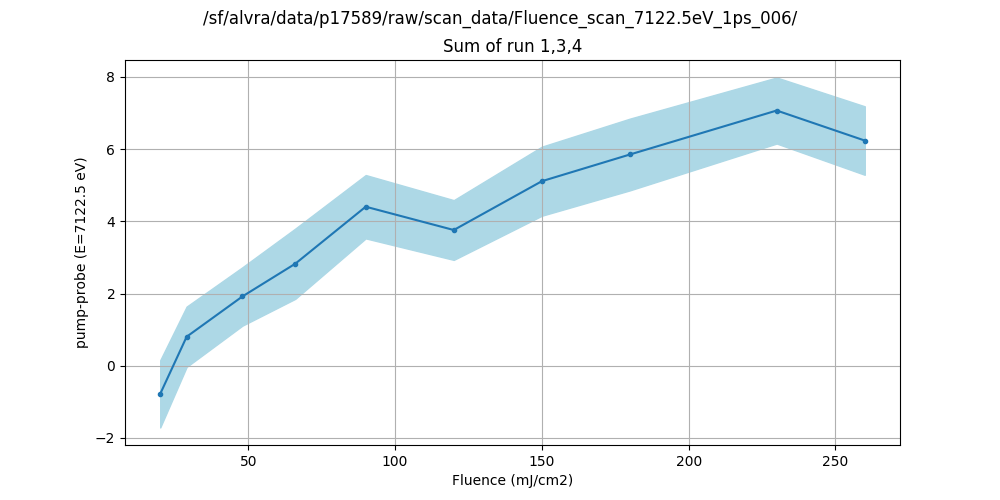

(array([71.4375, 70.0875, 68.625 , 67.275 , 65.8125, 64.4625, 63.    ,
        61.65  , 60.3   , 58.8375]),
 array([-0.77826836,  0.80302329,  1.91875015,  2.82471344,  4.40338911,
         3.75789497,  5.10986286,  5.84922088,  7.06680331,  6.23510603]),
 array([0.93184996, 0.83489726, 0.80869364, 0.97283342, 0.87707019,
        0.82734931, 0.9564096 , 0.99325213, 0.91433509, 0.94807469]))

In [113]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
plt.title(DIR,horizontalalignment='right')
low_err_pumpprobe_sum_10points = Pump_probe_sum_10points - err_Pump_probe_sum_10points 
high_err_pumpprobe_sum_10points = Pump_probe_sum_10points + err_Pump_probe_sum_10points

# plt.plot(Waveplate_deg_10p, scale*(Pump_probe_sum_10points), label="pump-probe",marker='.')
# plt.fill_between(Waveplate_deg_10p, scale*low_err_pumpprobe_sum_10points, scale*high_err_pumpprobe_sum_10points, color='lightblue')
plt.plot(Fluences_10p, scale*(Pump_probe_sum_10points), label="pump-probe",marker='.')
plt.fill_between(Fluences_10p, scale*low_err_pumpprobe_sum_10points, scale*high_err_pumpprobe_sum_10points, color='lightblue')

plt.grid()
plt.gca().set_title('Sum of run 1,3,4')
plt.xlabel('Fluence (mJ/cm2)')
plt.ylabel('pump-probe (E=7122.5 eV)')
Waveplate_deg_10p,Pump_probe_sum_10points,err_Pump_probe_sum_10points

In [97]:
# Waveplate_deg_20p=Waveplate_deg.copy()
# Pump_probe_05=Pump_probe.copy()
# err_Pump_probe_05=err_Pump_probe.copy()
# Pump_probe_06=Pump_probe.copy()
# err_Pump_probe_06=err_Pump_probe.copy()

In [105]:
# Pump_probe_sum_20points = Pump_probe_05 + Pump_probe_06
# err_Pump_probe_sum_20points = np.sqrt((err_Pump_probe_05)**2 + (err_Pump_probe_06)**2 )

# # save the output into a separate file:
# Waveplate_deg_20p = np.array([71.4375, 70.7625, 70.0875, 69.4125, 68.7375, 68.0625, 67.5, 66.825 , 66.15  , 65.475 , 64.125 , 63.45  , 62.775 , 62.1,61.425 , 60.75  , 60.075 , 59.4   , 58.725 , 58.1625, 57.4875])
# Fluences_20p = np.array([19.5,24,30,38,47,58,65,73,85,98,131,144,160,170,190,215,240,250,270,280,305])
# Pump_probe_sum_20points = np.array([-1.61153958,  0.68631979,         0, -0.17194471,  0.44331883, 1.55135328,  0.98433433,  3.38636867,  2.92695065,  3.62753615,2.99956369,  3.93513691,  4.35456725,  4.24859994,  4.10972255,3.03244665,  4.13305278,  4.46869464,  3.63342662,  3.42694698,4.41751867])
# err_Pump_probe_sum_20points = np.array([0.66701913, 0.63542542,        0, 0.62865825, 0.64578632,0.72208287, 0.62718265, 0.6379087 , 0.82559354, 0.6682077 ,0.66880007, 0.65778918, 0.74179769, 0.63572243, 0.76856639,0.59523471, 0.7061265 , 0.73459204, 0.66643996, 0.71151161,0.64969809])

<IPython.core.display.Javascript object>


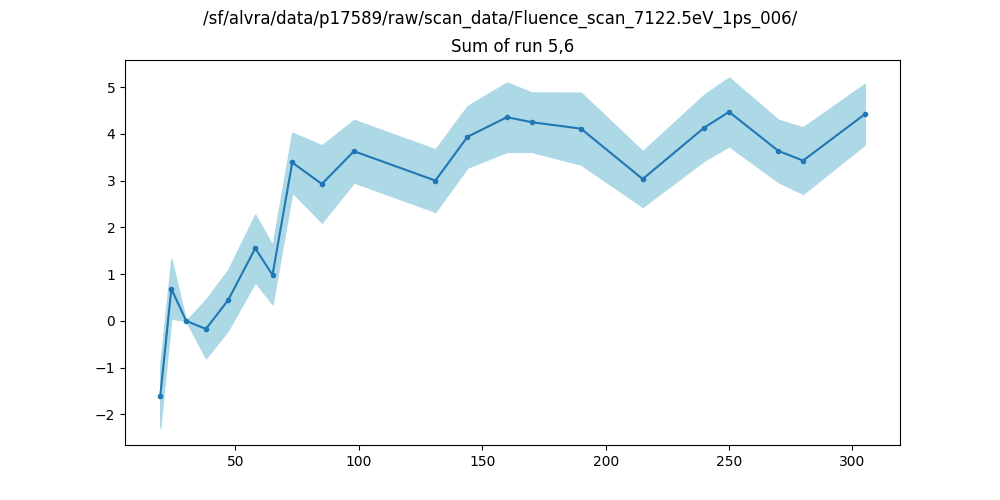

(array([71.4375, 70.7625, 70.0875, 69.4125, 68.7375, 68.0625, 67.5   ,
        66.825 , 66.15  , 65.475 , 64.125 , 63.45  , 62.775 , 62.1   ,
        61.425 , 60.75  , 60.075 , 59.4   , 58.725 , 58.1625, 57.4875]),
 array([-1.61153958,  0.68631979,  0.        , -0.17194471,  0.44331883,
         1.55135328,  0.98433433,  3.38636867,  2.92695065,  3.62753615,
         2.99956369,  3.93513691,  4.35456725,  4.24859994,  4.10972255,
         3.03244665,  4.13305278,  4.46869464,  3.63342662,  3.42694698,
         4.41751867]),
 array([0.66701913, 0.63542542, 0.        , 0.62865825, 0.64578632,
        0.72208287, 0.62718265, 0.6379087 , 0.82559354, 0.6682077 ,
        0.66880007, 0.65778918, 0.74179769, 0.63572243, 0.76856639,
        0.59523471, 0.7061265 , 0.73459204, 0.66643996, 0.71151161,
        0.64969809]))

In [109]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
plt.title(DIR,horizontalalignment='right')
low_err_pumpprobe_sum_20points = Pump_probe_sum_20points - err_Pump_probe_sum_20points 
high_err_pumpprobe_sum_20points = Pump_probe_sum_20points + err_Pump_probe_sum_20points

# plt.plot(Waveplate_deg_20p, scale*(Pump_probe_sum_20points), label="pump-probe",marker='.')
# plt.fill_between(Waveplate_deg_20p, scale*low_err_pumpprobe_sum_20points, scale*high_err_pumpprobe_sum_20points, color='lightblue')
plt.plot(Fluences_20p, scale*(Pump_probe_sum_20points), label="pump-probe",marker='.')
plt.fill_between(Fluences_20p, scale*low_err_pumpprobe_sum_20points, scale*high_err_pumpprobe_sum_20points, color='lightblue')

plt.gca().set_title('Sum of run 5,6')
Waveplate_deg_20p,Pump_probe_sum_20points,err_Pump_probe_sum_20points

<IPython.core.display.Javascript object>


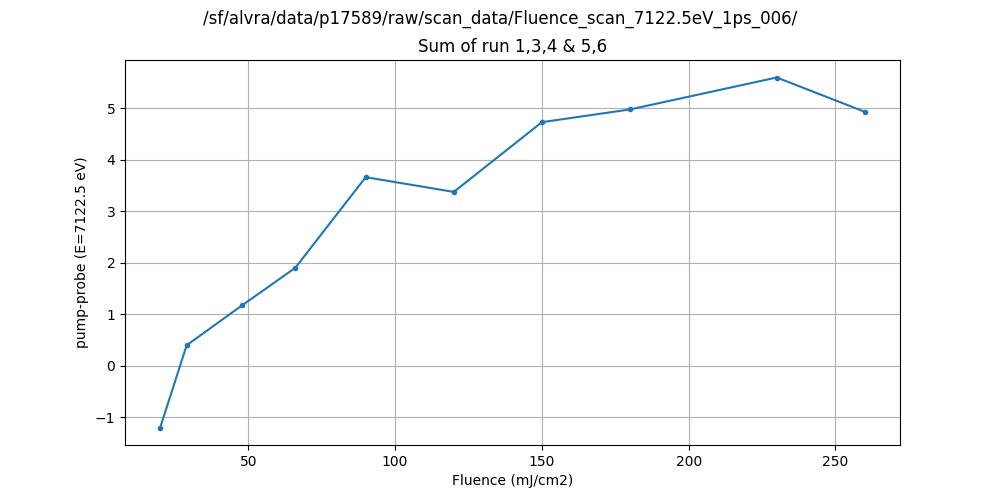

Text(0,0.5,'pump-probe (E=7122.5 eV)')

In [131]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1

# plt.plot(Fluences_10p, scale*(Pump_probe_sum_10points), label="pump-probe",marker='.')
# plt.fill_between(Fluences_10p, scale*low_err_pumpprobe_sum_10points, scale*high_err_pumpprobe_sum_10points, color='lightblue')

# plt.plot(Fluences_20p[:-2:2], scale*(Pump_probe_sum_20points[:-2:2]), label="pump-probe",marker='.')
# plt.fill_between(Fluences_20p[:-2:2], scale*low_err_pumpprobe_sum_20points[:-2:2], scale*high_err_pumpprobe_sum_20points[:-2:2], color='lightblue')

plt.plot(Fluences_10p, scale*(Pump_probe_sum_20points[:-2:2]+Pump_probe_sum_10points)/2, label="pump-probe",marker='.')
# plt.fill_between(Fluences_10p, scale*(low_err_pumpprobe_sum_20points[:-2:2]/2+low_err_pumpprobe_sum_10points/2), scale*(high_err_pumpprobe_sum_20points[:-2:2]/2+low_err_pumpprobe_sum_10points/2), color='lightblue')


plt.grid()
plt.gca().set_title('Sum of run 1,3,4 & 5,6')
plt.xlabel('Fluence (mJ/cm2)')
plt.ylabel('pump-probe (E=7122.5 eV)')